In [8]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from pymc3.distributions.dist_math import bound

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [9]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

(array([1.049e+03, 4.980e+02, 2.410e+02, 1.170e+02, 5.300e+01, 2.100e+01,
        1.600e+01, 2.000e+00, 1.000e+00, 2.000e+00]),
 array([3.57540907e-06, 2.48115073e-02, 4.96194392e-02, 7.44273710e-02,
        9.92353029e-02, 1.24043235e-01, 1.48851167e-01, 1.73659099e-01,
        1.98467030e-01, 2.23274962e-01, 2.48082894e-01]),
 <BarContainer object of 10 artists>)

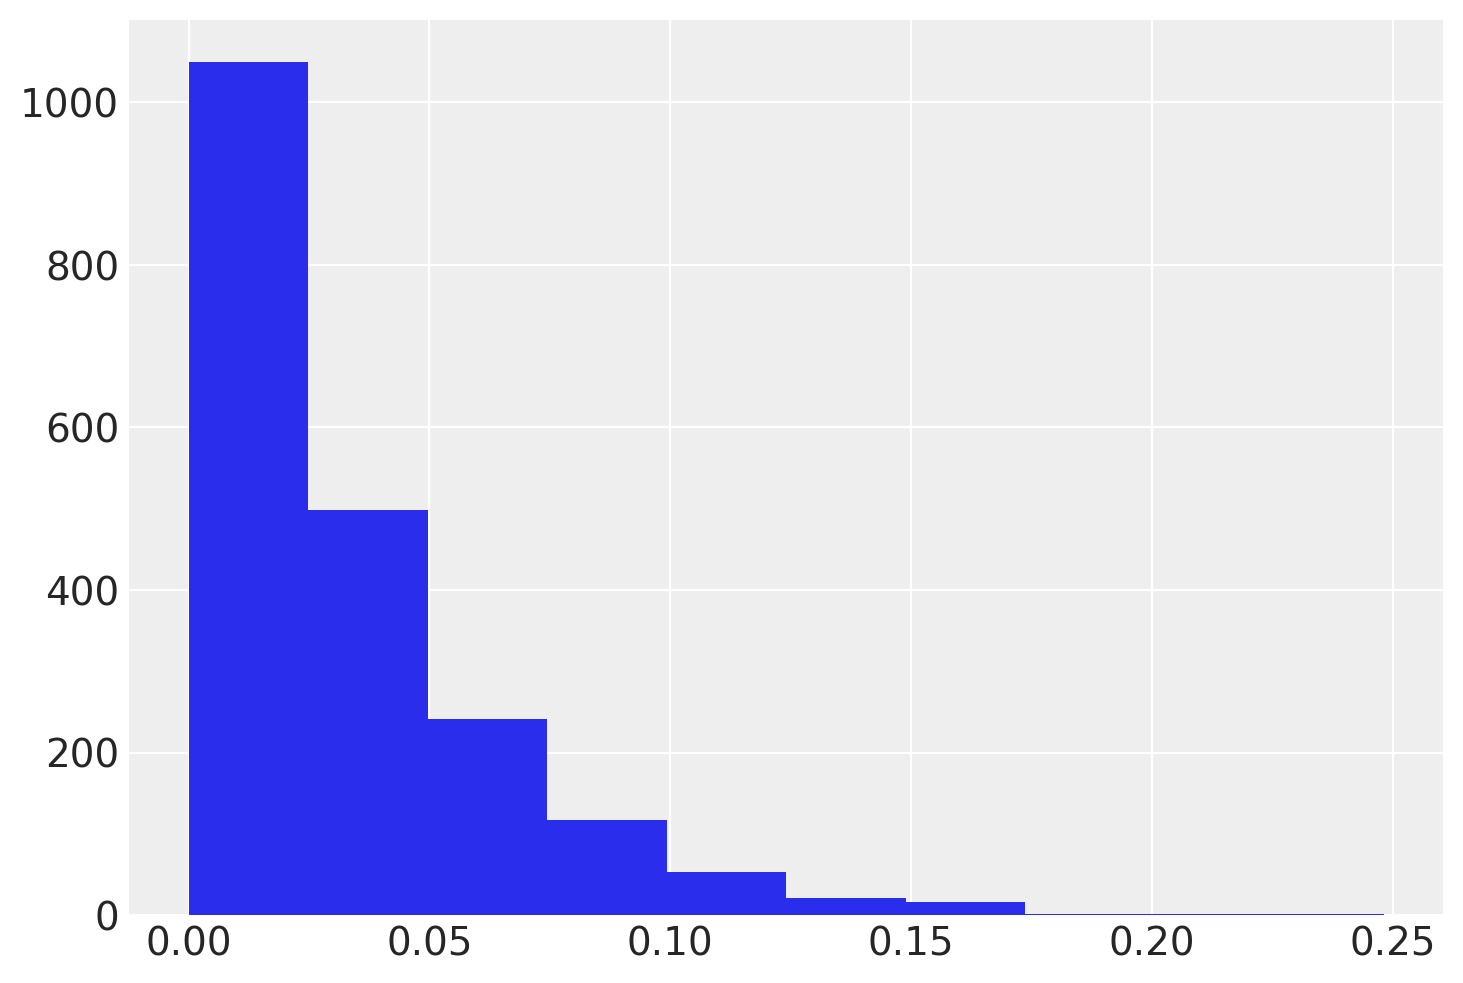

In [10]:
# simulate data from a known mixture distribution
np.random.seed(12345)  # set random seed for reproducibility

k = 1
ndata = 1000
# spread = 5
# centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution

v = np.random.randint(0, k, ndata)
data_1 = np.random.gamma(shape = 1, scale = 1/30, size = ndata)
data_2 = np.random.gamma(shape = 1, scale = 1/30, size = ndata)

data = np.append(data_1, data_2)
plt.hist(data)

In [11]:
#definir a GPD
#definir a mistura de gammas
#definir a densidade usando as duas
#https://docs.pymc.io/api/distributions/mixture.html
#https://docs.pymc.io/PyMC3_and_Theano.html

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>Metropolis: [xi]
>Metropolis: [sigma]
>Metropolis: [loc]
/usr/local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


/usr/local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 2 chains for 3_000 tune and 440 draw iterations (6_000 + 880 draws total) took 6 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
/usr/local/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'loc'}>,
        <AxesSubplot:title={'center':'loc'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'xi'}>,
        <AxesSubplot:title={'center':'xi'}>]], dtype=object)

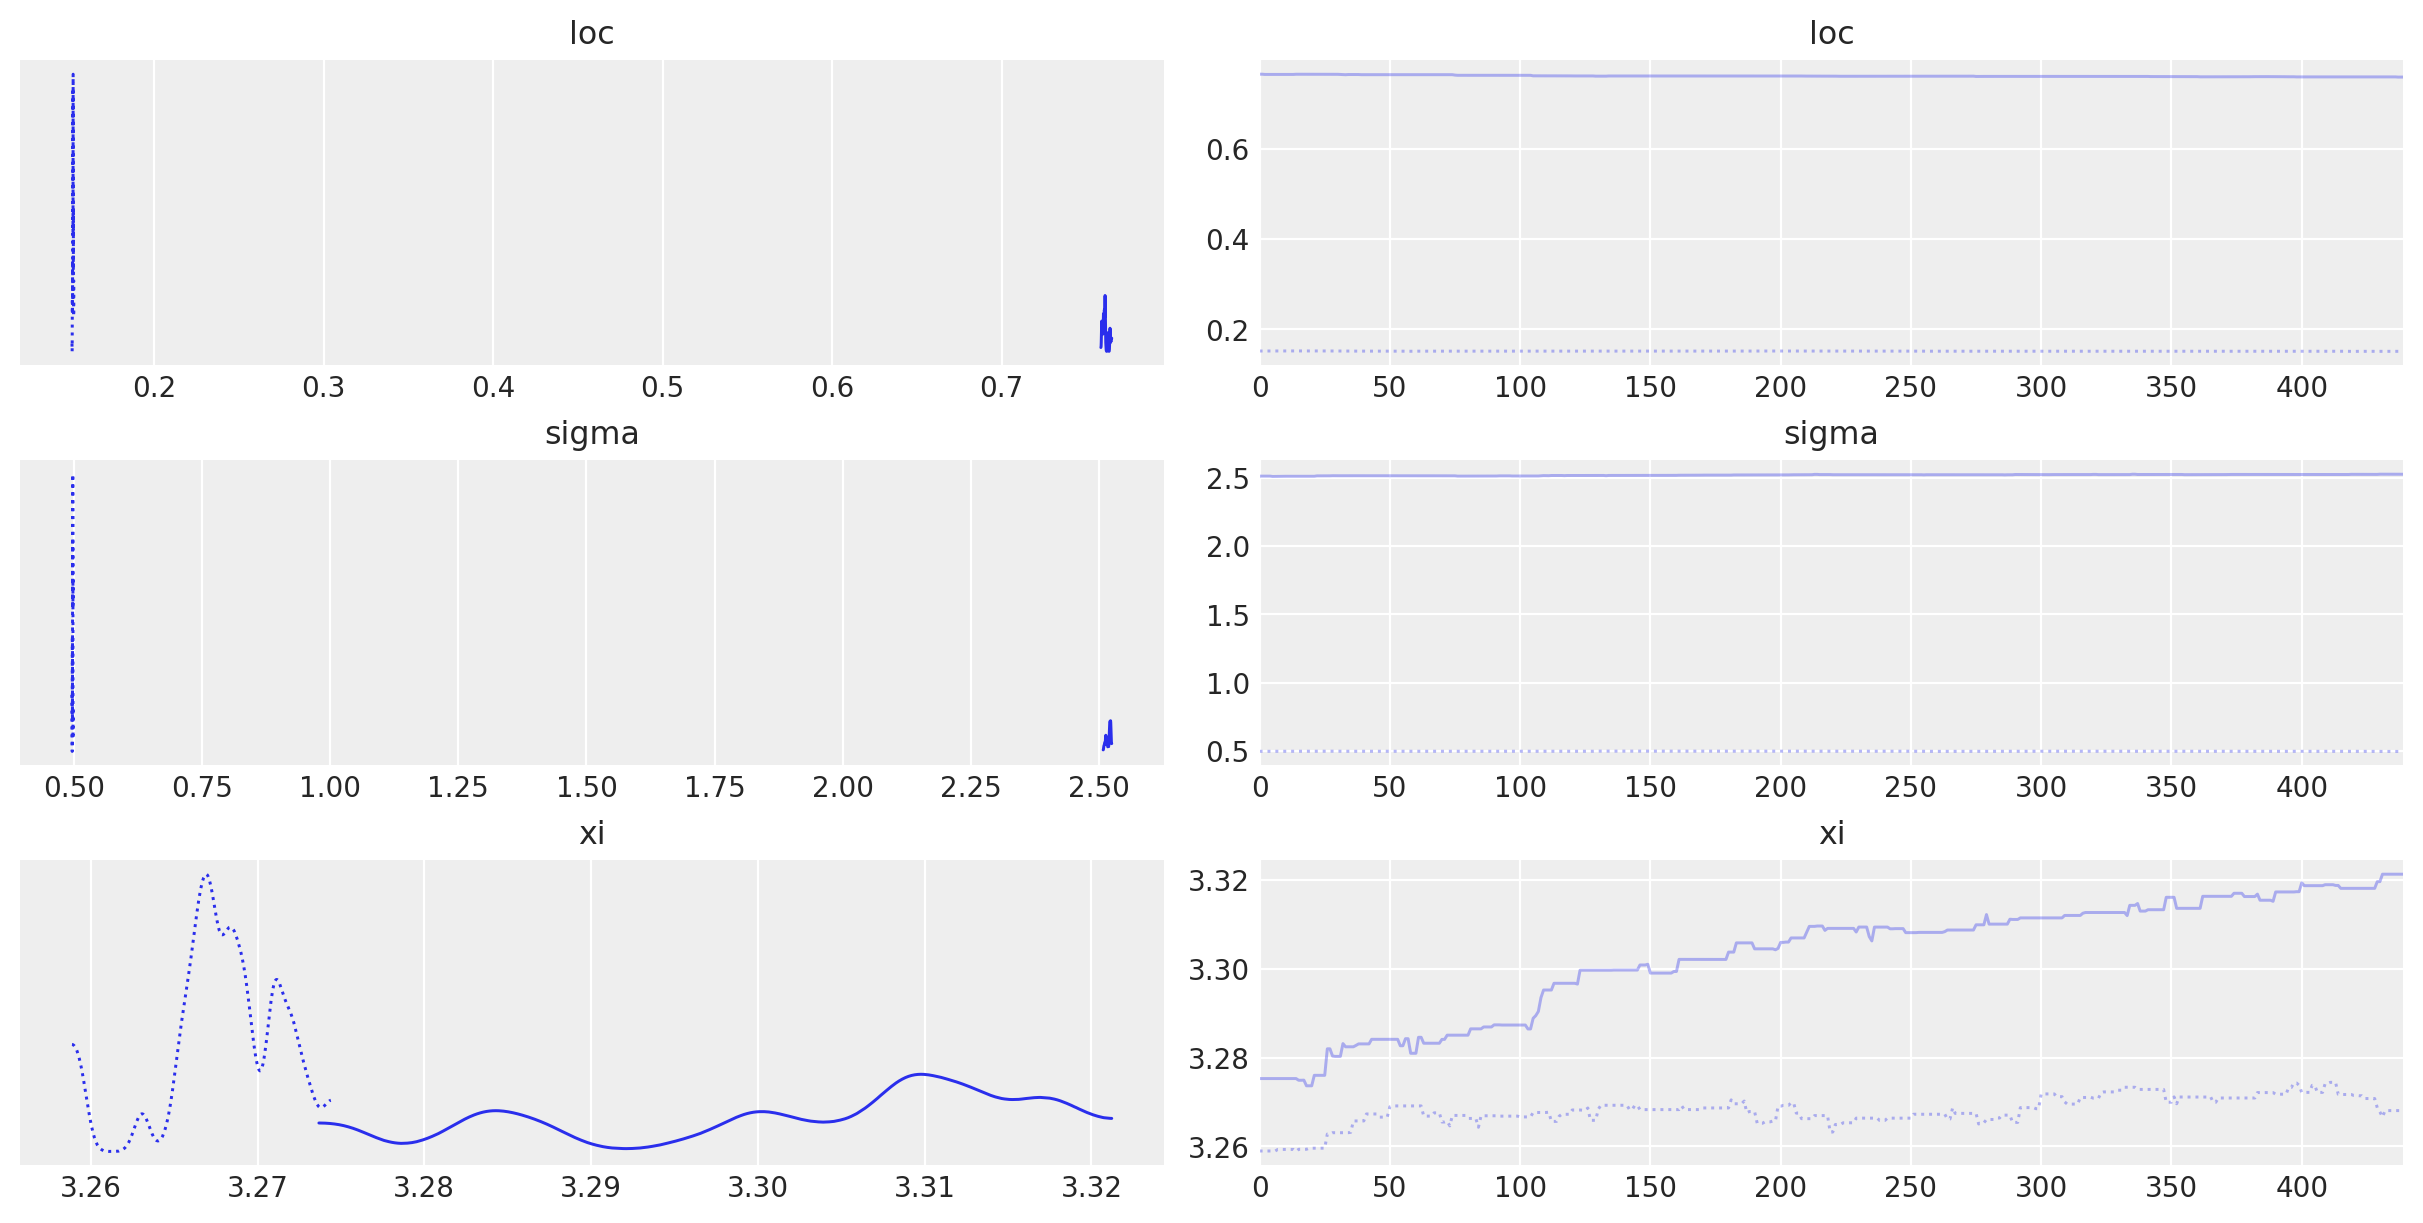

In [12]:
with pm.Model() as model_gev:
    loc = pm.Normal('loc', mu=3, sigma=10)
    sig=pm.Normal('sigma', mu=0.24, sigma=10)
    xi = pm.Normal('xi', mu=0, sigma=10)

    def gev_logp(value):
        scaled = (value - loc) / sig
        logp = -(tt.log(sig)
                 + ((xi + 1) / xi) * tt.log1p(xi * scaled)
                 + (1 + xi * scaled) ** (-1/xi))
        alpha = loc - sig/xi
        bounds = tt.switch(xi > 0, xi > alpha, xi < alpha)
        
        return bound(logp, bounds, xi!= 0)

    gev = pm.DensityDist('gev', gev_logp, observed=data)
    step = pm.Metropolis()
    trace = pm.sample(10000, chains=4, tune=3000,step=step,start={'loc': 1.0, 'sigma': 1.0, 'xi': 1.0})
    
pm.traceplot(trace)